<a href="https://colab.research.google.com/github/xxziris/protein_ligand_binding/blob/main/BS6207_Project_visualization_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install sparse

     |████████████████████████████████| 81kB 8.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from sparse import COO
import sparse
import matplotlib.pyplot as plt

##0. Utils

In [ ]:
# define function to import data from pdb files
def read_pdb(filename):
	
  with open(filename, 'r') as file:
    strline_L = file.readlines()
		# print(strline_L)

  X_list = list()
  Y_list = list()
  Z_list = list()
  atomtype_list = list()
  for strline in strline_L:
		# removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()

    line_length = len(stripped_line)
		# print("Line length:{}".format(line_length))
    if line_length < 78:
      print("ERROR: line length is different. Expected>=78, current={}".format(line_length))
		
    X_list.append(float(stripped_line[30:38].strip()))
    Y_list.append(float(stripped_line[38:46].strip()))
    Z_list.append(float(stripped_line[46:54].strip()))

    atomtype = stripped_line[76:78].strip()
    if atomtype == 'C':
      atomtype_list.append(1) # 'h' means hydrophobic
    else:
      atomtype_list.append(0) # 'p' means polar

  pdb = np.array([X_list, Y_list, Z_list, atomtype_list])
	
  return pdb


In [ ]:
# define function for voxelization
def voxelize(pro_filename, lig_filename, max_side = 30, grid = 4):
  # import the pdb file as array
  pro = read_pdb(pro_filename).astype(np.float32)
  lig = read_pdb(lig_filename).astype(np.float32)

  # calculate box_size
  box_size = np.ceil(2 * max_side / grid + 1)

  # get the centroid of the ligand/protein
  lig_cent = np.mean(lig[:3, :], axis = 1, keepdims = True)  
  pro_cent = np.mean(pro[:3, :], axis = 1, keepdims = True)

  # shift the protein by the centroid of ligand at 0
  for i in range(3):
    lig[i] = lig[i] - lig_cent[i]
    pro[i] = pro[i] - lig_cent[i]
  
  # combine the coordinate and atom type of protein and ligand
  all_coord = np.c_[pro[:3], lig[:3]]
  lig[3] = np.where(lig[3] == 0, 100, 200)
  all_atom = np.r_[pro[3], lig[3]]

  # round coordinate to the nearest grid point
  all_coord = (all_coord + max_side) / grid
  
  # remove atoms outside the box
  check = ((all_coord>0) & (all_coord < box_size)).all(axis = 0)
  all_coord = all_coord[:,check]
  all_atom = all_atom[check]

  # round the coordinates to integer
  all_coord = (all_coord).astype(int)

  # create the sparse matrix
  s = sparse.COO(all_coord, all_atom, shape = (int(box_size), int(box_size), int(box_size)))  
  return s

In [ ]:
# read all training filenames
import os

pro_filename = []
lg_filename = []
directory = os.fsencode('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/')
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if '_pro_' in filename: 
       pro_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue
     else:
       lg_filename.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/', filename))
       continue

In [ ]:
lg_filename[0]

'/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/2501_lig_cg.pdb'

In [ ]:
# create the label
def get_label(pro, lig):
  labels = []
  num = min(len(pro), len(lig))
  for i in range(num):
    if pro[i][-15:-11] == lig[i][-15:-11]:
      labels.append(0) # bind
    else:
      labels.append(1) #dont bind
  return labels

## 1. Protein/ligand visualization

In [ ]:
# visualize a protein-ligand binding pair
pro = '/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/1216_pro_cg.pdb'
lig = '/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/training_data/1216_lig_cg.pdb'
pro_array = read_pdb(pro)[:3]
lig_array = read_pdb(lig)[:3]

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

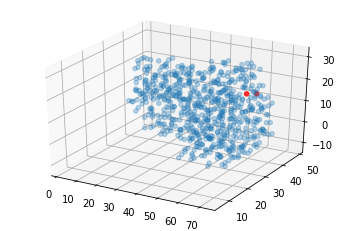

In [ ]:
# initial state
ax = plt.axes(projection = '3d')
ax.scatter3D(pro_array[0], pro_array[1], pro_array[2], alpha = 0.3)
ax.scatter3D(lig_array[0], lig_array[1], lig_array[2], color = 'red', alpha = 0.8)

In [ ]:
# center by the centroid of ligands
# get the centroid of the ligand/protein
lig_cent = np.mean(lig_array[:3, :], axis = 1, keepdims = True)  
pro_cent = np.mean(pro_array[:3, :], axis = 1, keepdims = True)

# shift the protein by the centroid of ligand at 0
for i in range(3):
  lig_array[i] = lig_array[i] - lig_cent[i]
  pro_array[i] = pro_array[i] - lig_cent[i]

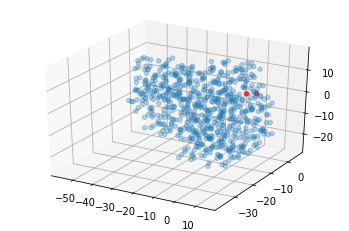

In [ ]:
# centered
ax = plt.axes(projection = '3d')
ax.scatter3D(pro_array[0], pro_array[1], pro_array[2], alpha = 0.3)
ax.scatter3D(lig_array[0], lig_array[1], lig_array[2], color = 'red', alpha = 0.8)

In [ ]:
# round coordinate to the nearest grid point
lig_array = (lig_array + 30) / 4
pro_array = (pro_array + 30) / 4

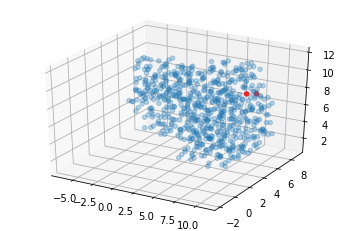

In [ ]:
# shifted and scaled
ax = plt.axes(projection = '3d')
ax.scatter3D(pro_array[0], pro_array[1], pro_array[2], alpha = 0.3)
ax.scatter3D(lig_array[0], lig_array[1], lig_array[2], color = 'red', alpha = 0.8)

In [ ]:
# remove atoms outside the box
check_lig = ((lig_array>=0) & (lig_array < 16)).all(axis = 0)
lig_array = lig_array[:,check_lig]

check_pro = ((pro_array>=0) & (pro_array < 16)).all(axis = 0)
pro_array = pro_array[:,check_pro]

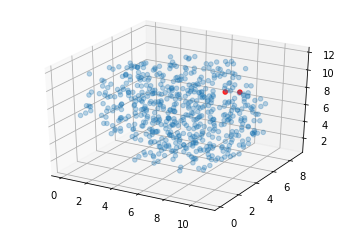

In [ ]:
# trimmed
ax = plt.axes(projection = '3d')
ax.scatter3D(pro_array[0], pro_array[1], pro_array[2], alpha = 0.3)
ax.scatter3D(lig_array[0], lig_array[1], lig_array[2], color = 'red', alpha = 0.8)

In [ ]:
# round the coordinates to integer
lig_array = np.round((lig_array).astype(int))
pro_array = np.round((pro_array).astype(int))

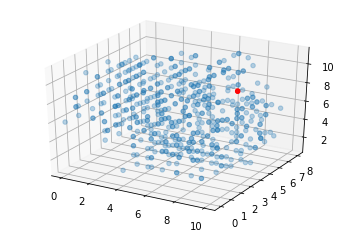

In [ ]:
# rounded
ax = plt.axes(projection = '3d')
ax.scatter3D(pro_array[0], pro_array[1], pro_array[2], alpha = 0.3)
ax.scatter3D(lig_array[0], lig_array[1], lig_array[2], color = 'red', alpha = 0.8)

## 2. Load the best model

In [ ]:
 # trial 1 - CNN
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.cnn_layers = nn.Sequential(
        nn.Conv3d(1, 8, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(8),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=1),
        # Defining another 2D convolution layer
        nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(16),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
        # Defining another 2D convolution layer
        nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=0),
        nn.BatchNorm3d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool3d(kernel_size=2, stride=2),
    )

    self.linear_layers = nn.Sequential(
            nn.Dropout(p = 0.1),
            nn.Linear(32 * 4 * 4 * 4 , 32),
            nn.ReLU(),
            nn.Linear(32,2)
        )

  def forward(self, x):
    x = self.cnn_layers(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.linear_layers(x)
    return x

In [ ]:
model = Net()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/model_12weight_trial1_lostfunction.pt'))

<All keys matched successfully>

## Import test set

In [ ]:
pro_filename_test = []
lg_filename_test = []
import os
directory = os.fsencode('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/testing_data/')
    
for file in os.listdir(directory):
     filename = os.fsdecode(file)
     if '_pro_' in filename: 
       pro_filename_test.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/testing_data/', filename))
       continue
     else:
       lg_filename_test.append(os.path.join('/content/drive/MyDrive/Colab Notebooks/BS6207/Project/training_data.zip (Unzipped Files)/testing_data/', filename))
       continue

In [ ]:
pro_filename_test = sorted(pro_filename_test)
lg_filename_test = sorted(lg_filename_test)

In [ ]:

# read test file
def read_pdb_test(filename):
	
  with open(filename, 'r') as file:
	  strline_L = file.readlines()
	  # print(strline_L)

  X_list = list()
  Y_list = list()
  Z_list = list()
  atomtype_list = list()
  for strline in strline_L: 
    # removes all whitespace at the start and end, including spaces, tabs, newlines and carriage returns
    stripped_line = strline.strip()
    # print(stripped_line)

    splitted_line = stripped_line.split('\t')
		
    X_list.append(float(splitted_line[0]))
    Y_list.append(float(splitted_line[1]))
    Z_list.append(float(splitted_line[2]))
    # atomtype_list.append(str(splitted_line[3]))
    if str(splitted_line[3]) == 'h':  
      atomtype_list.append(1) # 'h' means hydrophobic
    else:
      atomtype_list.append(0) # 'p' means polar


  pdb = np.array([X_list, Y_list, Z_list, atomtype_list])
	
  return pdb


In [ ]:
# voxelization for test file
def voxelize_test(pro_filename, lig_filename, max_side = 24, grid = 2):
  # import the pdb file as array
  pro = read_pdb_test(pro_filename).astype(np.float32)
  lig = read_pdb_test(lig_filename).astype(np.float32)

  # calculate box_size
  box_size = np.ceil(2 * max_side / grid + 1)

  # get the centroid of the ligand/protein
  lig_cent = np.mean(lig[:3, :], axis = 1, keepdims = True)  
  pro_cent = np.mean(pro[:3, :], axis = 1, keepdims = True)

  # shift the protein by the centroid of ligand at 0
  for i in range(3):
    lig[i] = lig[i] - lig_cent[i]
    pro[i] = pro[i] - lig_cent[i]
  
  # combine the coordinate and atom type of protein and ligand
  all_coord = np.c_[pro[:3], lig[:3]]
  lig[3] = np.where(lig[3] == 0, 100, 200)
  all_atom = np.r_[pro[3], lig[3]]

  # round coordinate to the nearest grid point
  all_coord = (all_coord + max_side) / grid
  
  # remove atoms outside the box
  check = ((all_coord>0) & (all_coord < box_size)).all(axis = 0)
  all_coord = all_coord[:,check]
  all_atom = all_atom[check]

  # round the coordinates to integer
  all_coord = (all_coord).astype(int)

  # create the sparse matrix
  s = sparse.COO(all_coord, all_atom, shape = (int(box_size), int(box_size), int(box_size)))  

  return s

In [ ]:
model.eval()
pro = []
lig = []
bind_score = []
notbind_score = []
for i in range(len(pro_filename_test)):
  for j in range(len(lg_filename_test)):
    pro.append(i+1)
    lig.append(j+1)
    temp = voxelize_test(pro_filename=pro_filename_test[i], lig_filename=lg_filename_test[j], max_side=24, grid=2)
    temp = torch.from_numpy(COO.todense(temp))
    temp = torch.reshape(temp, (1,1,25,25,25))
    output = model(temp)
    output = torch.softmax(output, dim = 1)
    output = output.detach().numpy()
    #print(output)
    bind_score.append(output[0][1])
    notbind_score.append(output[0][0])

In [ ]:
df = pd.DataFrame({'pro_id': pro, 'lig_id': lig, 'bind_score': bind_score, 'notbind_score': notbind_score})
df.head()

,pro_id,lig_id,bind_score,notbind_score
0,1,1,0.000168,0.999832
1,1,2,0.000001,0.999999
2,1,3,0.000490,0.999510
3,1,4,0.000026,0.999974
4,1,5,0.000006,0.999994


In [ ]:
# exclude not bind pairs
# df = df[df.bind_score > df.notbind_score]
# sort the highest bind score per protein
df_top = pd.DataFrame(df.groupby(['pro_id'])['bind_score'].nlargest(10)).reset_index()
temp = list(df.lig_id.loc[df_top.level_1])
df_top['lig_id'] = temp
df_top.head()

,pro_id,level_1,bind_score,lig_id
0,1,765,0.994050,766
1,1,77,0.991080,78
2,1,103,0.988755,104
3,1,750,0.984528,751
4,1,581,0.979330,582


In [ ]:
# generate the output file
pro_id = []
lig1_id = []
lig2_id = []
lig3_id = []
lig4_id = []
lig5_id = []
lig6_id = []
lig7_id = []
lig8_id = []
lig9_id = []
lig10_id = []
for i in range(1, len(pro_filename_test) + 1):
  #print(i)
  pro_id.append(i)
  temp = df_top[df_top.pro_id == i].reset_index(drop = True)
  #print(temp.level_1[0])
  lig1_id.append(temp.lig_id[0])
  lig2_id.append(temp.lig_id[1])
  lig3_id.append(temp.lig_id[2])
  lig4_id.append(temp.lig_id[3])
  lig5_id.append(temp.lig_id[4])
  lig6_id.append(temp.lig_id[5])
  lig7_id.append(temp.lig_id[6])
  lig8_id.append(temp.lig_id[7])
  lig9_id.append(temp.lig_id[8])
  lig10_id.append(temp.lig_id[9])

test_predictions = pd.DataFrame({'pro_id': pro_id, 'lig1_id': lig1_id, 'lig2_id': lig2_id, 'lig3_id': lig3_id, 'lig4_id': lig4_id,
                                 'lig5_id': lig5_id, 'lig6_id': lig6_id, 'lig7_id': lig7_id, 'lig8_id': lig8_id, 'lig9_id': lig9_id, 'lig10_id': lig10_id})
test_predictions

,pro_id,lig1_id,lig2_id,lig3_id,lig4_id,lig5_id,lig6_id,lig7_id,lig8_id,lig9_id,lig10_id
0,1,766,78,104,751,582,489,534,156,664,388
1,2,167,403,1,729,285,148,593,334,587,765
2,3,534,314,496,259,582,716,455,593,638,449
3,4,612,512,449,674,439,649,378,518,760,710
4,5,466,91,14,222,90,650,493,315,624,385
...,...,...,...,...,...,...,...,...,...,...,...
819,820,425,267,176,648,36,313,153,694,228,448
820,821,374,606,772,724,358,417,3,713,508,136
821,822,177,502,345,40,528,348,401,82,667,353
822,823,600,410,58,356,763,455,644,112,727,545


In [ ]:
# export to txt
test_predictions.to_csv('test_predictions.txt', header = True, index = False, sep = '\t')